In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import os 
import gc

import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim


from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


In [2]:
gList = [
            '/home/jua/corsika/run/energy_var/npz/square/0514/gamma_square_n51.npz',
            '/home/jua/corsika/run/energy_var/npz/square/0513/gamma_square_n51_0.npz',
             '/home/jua/corsika/run/energy_var/npz/square/0513/gamma_square_n51_1.npz',
             '/home/jua/corsika/run/energy_var/npz/square/0513/gamma_square_n51_2.npz',
             '/home/jua/corsika/run/energy_var/npz/square/0513/gamma_square_n51_3.npz',
             '/home/jua/corsika/run/energy_var/npz/square/0513/gamma_square_n51_4.npz',
             '/home/jua/corsika/run/energy_var/npz/square/0513/gamma_square_n51_5.npz',
             '/home/jua/corsika/run/energy_var/npz/square/0513/gamma_square_n51_6.npz',
             '/home/jua/corsika/run/energy_var/npz/square/0513/gamma_square_n51_7.npz',
             '/home/jua/corsika/run/energy_var/npz/square/0513/gamma_square_n51_8.npz',
             '/home/jua/corsika/run/energy_var/npz/square/0513/gamma_square_n51_9.npz'
            ]

In [3]:
pList = ['/home/jua/corsika/run/energy_var/npz/square/0513/proton_square_n51.npz',
             '/home/jua/corsika/run/energy_var/npz/square/0514/proton_square_n51_0.npz',
             '/home/jua/corsika/run/energy_var/npz/square/0514/proton_square_n51_1.npz',
             '/home/jua/corsika/run/energy_var/npz/square/0514/proton_square_n51_2.npz',
             '/home/jua/corsika/run/energy_var/npz/square/0514/proton_square_n51_3.npz',
             '/home/jua/corsika/run/energy_var/npz/square/0514/proton_square_n51_4.npz',
             '/home/jua/corsika/run/energy_var/npz/square/0514/proton_square_n51_5.npz',
             '/home/jua/corsika/run/energy_var/npz/square/0514/proton_square_n51_6.npz',
             '/home/jua/corsika/run/energy_var/npz/square/0514/proton_square_n51_7.npz',
             '/home/jua/corsika/run/energy_var/npz/square/0514/proton_square_n51_8.npz',
             '/home/jua/corsika/run/energy_var/npz/square/0514/proton_square_n51_9.npz'
            ]

In [7]:
# binHitAll upper & lower
pbinHitAll = [[[],[]] for i in range(9)]
gbinHitAll = [[[],[]] for i in range(9)]

In [8]:
perPMTHit = [6.7,10.5,16.2,24.7,35.6,48.5,61.8,74.0,85.0,100.0]

In [9]:
# bin 1,2,3
def SeparateBinHit(image, energy, binHit):
    n = len(image)
    for imu, iml, im, en in zip(image[:,0][:n],image[:,3][:n], image[:n], energy[:n]):
        percent = (len(imu[imu!=0])+len(iml[iml!=0]))*100/(51.0*51.0*2)
        for i in range(3):
            if perPMTHit[i] < percent < perPMTHit[i+1]:
                binHit[i][0].append(im)
                binHit[i][1].append(en)

In [10]:
for file in gList:
    gamma = np.load(file)
    gim = np.asarray(gamma['arr_0'],dtype='uint8')
    gen = gamma['arr_1'] 
    SeparateBinHit(gim, gen, gbinHitAll)
    del gamma, gim, gen
    gc.collect()

In [18]:
for file in pList:
    proton = np.load(file)
    pim = np.asarray(proton['arr_0'],dtype='uint8')
    pen = proton['arr_1'] 
    SeparateBinHit(pim, pen, pbinHitAll)
    del proton, pim, pen
    gc.collect()

In [12]:
def plotting(histoBin, particle, arr, upperlower, Bin, c):
    numEvt = []
    logbins = np.logspace(np.log10(100),np.log10(100000),histoBin)
    #fig, ax = plt.subplots(1,Bin,figsize=(7*Bin,5))
    fig, ax = plt.subplots(3,3,figsize=(20,20))
    for i in range(3):
        for j in range(3):
            x = arr[i*3+j][1]
            numEvt.append(len(x))
            n, bins, patches = ax[i][j].hist(x, bins=logbins, color=c)
            ax[i][j].set(title='Energy distribution (B={})'.format(i*3+j+1))
            ax[i][j].set_xlabel('Energy of Event [GeV]')
            ax[i][j].set_ylabel('# of Event')
            ax[i][j].set_xscale('log')
            #ax[i].text(0.16, 0.9, r'# of event = %i' %(len(x)), alpha=1,
            #     va="center", ha="center", size=10, transform=ax[i].transAxes)

    plt.savefig('plots/energy_distribution/sq_{}_{}_energy_distribution.png'.format(particle,upperlower))
    plt.show()
    print('# of Event : ',numEvt)

In [57]:
def plotting(histoBin, garr, parr, Bin):
    gnumEvt = []
    pnumEvt = []
    logbins = np.logspace(np.log10(100),np.log10(100000),histoBin)
    #fig, ax = plt.subplots(1,Bin,figsize=(7*Bin,7))
    fig, ax = plt.subplots(3,3,figsize=(35,35))
    for i in range(3):
        for j in range(3):
            x = garr[j+i*3][1]
            y = parr[j+i*3][1]

            gnumEvt.append(len(x))
            pnumEvt.append(len(y))

            n, bins, patches = ax[i][j].hist(x, bins=logbins, color='tab:orange',alpha=0.6,label='gamma')
            n, bins, patches = ax[i][j].hist(y, bins=logbins, color='tab:blue',alpha=0.6,label='proton')

            #ax[i][j].set(title='Energy distribution (B={})'.format(j+1+i*3))
            #ax[i][j].set_title('B={}'.format(j+1+i*3), fontsize=35)
            if i == 2 and j==1:
                ax[i][j].set_xlabel('Energy [GeV]',fontsize=50)
                ax[i][j].xaxis.set_label_coords(0.5, -0.15)
            #ax[i][j].set_ylabel('# of Event',fontsize=28)
            if i == 1 and j==0:
                ax[i][j].set_ylabel('# of Event',fontsize=55)
                ax[i][j].yaxis.set_label_coords(-0.25,0.5)

            ax[i][j].set_xscale('log')
            if i==0 and j==2:
                ax[i][j].legend(fontsize=40,loc = (0.48,0.75))
                #ax[i][j].legend(fontsize=40,bbox_to_anchor=(0.48, 0.75, 0.5, 0.5))
                
                #ax[i][j].legend(fontsize=35) 
            #ax[i][j].set_xticklabels(fontsize=16)
            ax[i][j].tick_params(axis = 'both', labelsize =38)
            #ax[i][j].tick_params(axis = 'y', labelsize =38)
            ty = 0.88
            tx = 0.15
            #if i!=0:
            #    tx = 0.25
            t = ax[i][j].text(tx, ty,'B={}'.format(j+1+i*3), alpha=1,
                 va="center", ha="center", size=60, transform=ax[i][j].transAxes)
            t.set_bbox(dict(facecolor='white', alpha=1,edgecolor='white'))
            
    #st = fig.suptitle("Energy Distribution", fontsize=110, y=0.96)
    plt.savefig('plots/energy_distribution/energy_distribution.pdf')
    plt.show()
    print('# of Gamma Event : ' ,gnumEvt)
    print('# of Proton Event : ',pnumEvt)

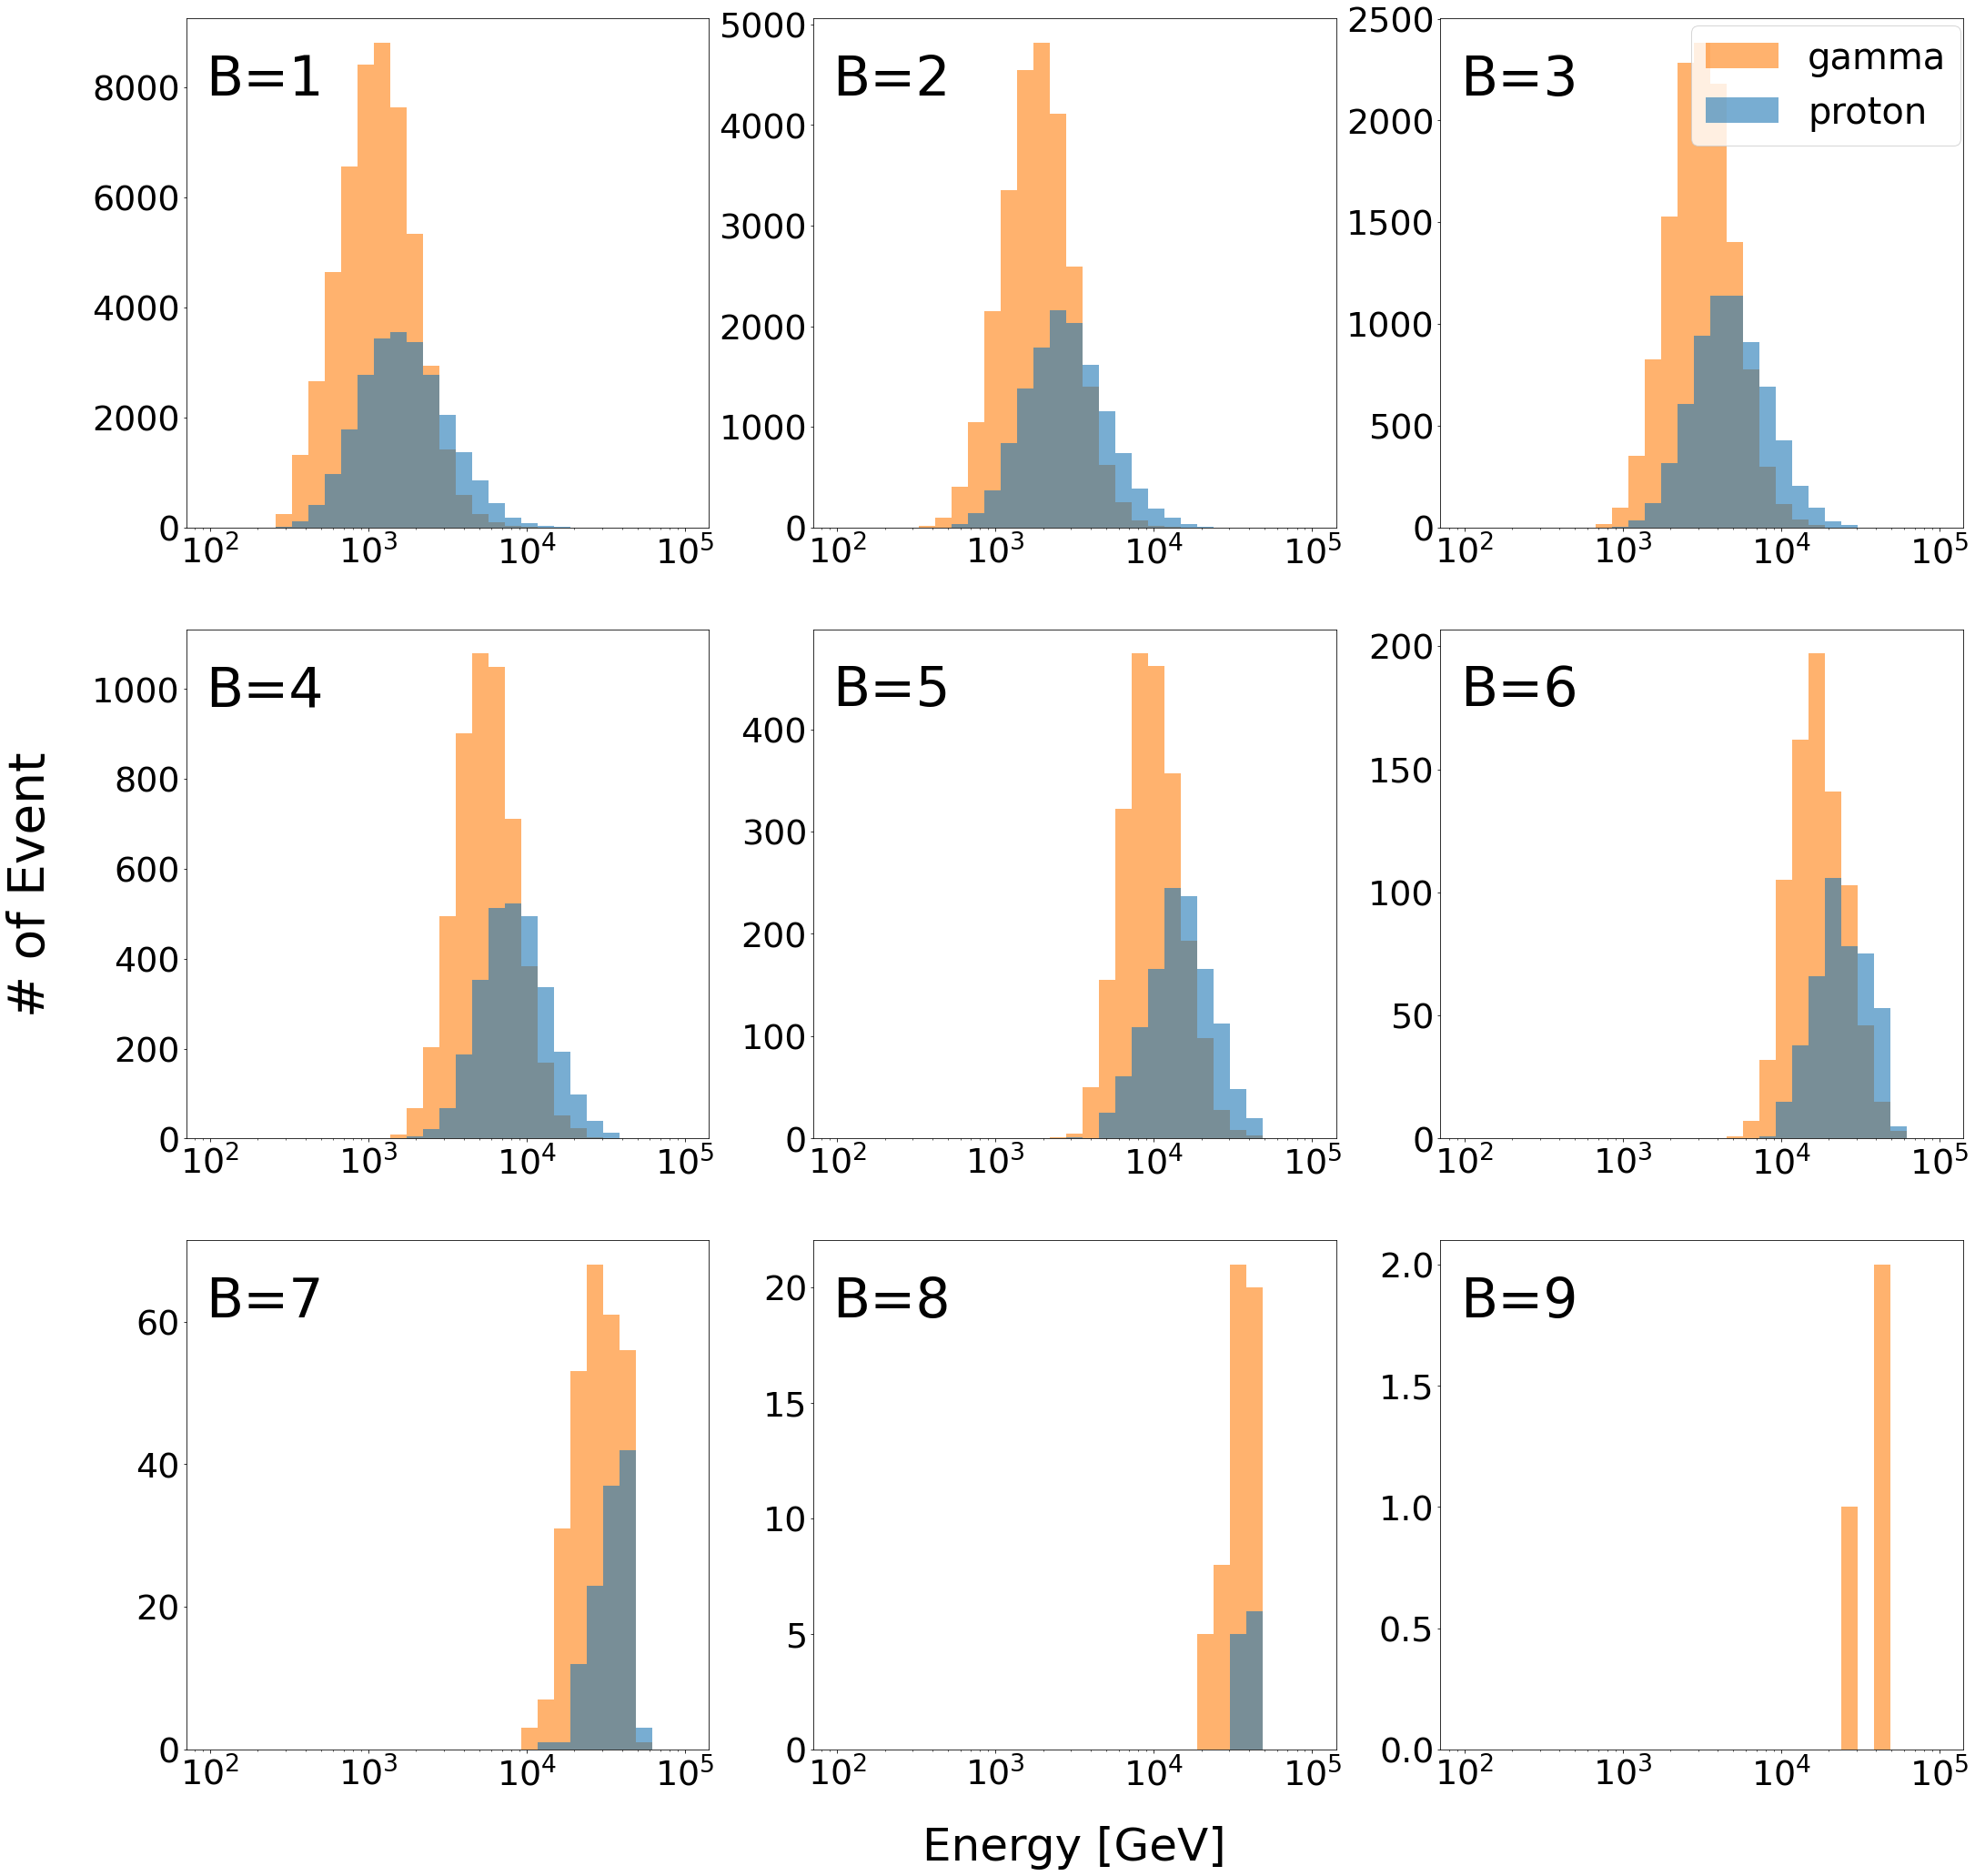

# of Gamma Event :  [50938, 25505, 12317, 5147, 2159, 814, 287, 59, 21]
# of Proton Event :  [24227, 12969, 6683, 2844, 1190, 437, 119, 11, 8]


In [58]:
plotting(30, gbinHitAll, pbinHitAll, 9)

In [88]:
#plotting(30, gbinHit, pbinHit, 9)

In [42]:
#plotting(30, 'proton', pbinHitAll, 'All', 9, 'tab:blue')

In [ ]:
#plotting(30, 'gamma', gbinHitAll, 'All', 9, 'tab:orange')

In [19]:
for i in range(9):
    #gbinHitAll[i][0] = np.asarray(gbinHitAll[i][0])
    #gbinHitAll[i][1] = np.asarray(gbinHitAll[i][1])
    pbinHitAll[i][0] = np.asarray(pbinHitAll[i][0])
    pbinHitAll[i][1] = np.asarray(pbinHitAll[i][1])
    #np.savez_compressed('/home/jua/corsika/run/energy_var/npz/square/bin/gamma_energy_bin{}_all.npz'.format(i+1),
    #                image=np.asarray(gbinHitAll[i][0]),energy=np.asarray(gbinHitAll[i][1]))
    np.savez_compressed('/home/jua/corsika/run/energy_var/npz/square/bin/proton_energy_bin{}_all.npz'.format(i+1),
                    image=np.asarray(pbinHitAll[i][0]),energy=np.asarray(pbinHitAll[i][1]))

In [ ]:
bin1 = np.load('/home/jua/corsika/run/energy_var/npz/square/bin/gamma_energy_bin1_all.npz')
bin2 = np.load('/home/jua/corsika/run/energy_var/npz/square/bin/gamma_energy_bin2_all.npz')

In [ ]:
gbin1 = np.load('/home/jua/corsika/run/energy_var/npz/0511/bin/gamma_energy_bin1_all.npz')
pbin1 = np.load('/home/jua/corsika/run/energy_var/npz/0511/bin/proton_energy_bin1_all.npz')

In [ ]:
len(gbin1['image'])

In [ ]:
len(pbinHitAll[0][0])